## On Importe les librairies de base

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## On importe les données, on réalise une eda pour ne garder que certaines features et changer certaines variables et remplacer les NA on supprime les na et on normalise en données numérique le sexe

In [41]:
# titanic = sns.load_dataset('titanic')
titanic = pd.read_csv("train.csv")
titanic.columns= titanic.columns.str.strip().str.lower()
titanic.head()


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## On commence l'EDA

(891, 12)


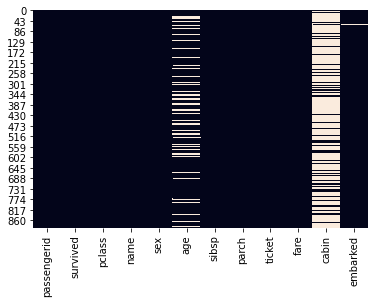

In [42]:
df = titanic.copy()
sns.heatmap(df.isna(), cbar=False)
(df.isna().sum()/df.shape[0]).sort_values(ascending=True)
print(df.shape)

## Analyse des variables : corrélations

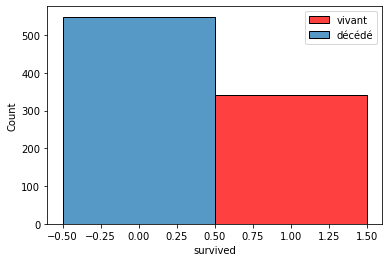

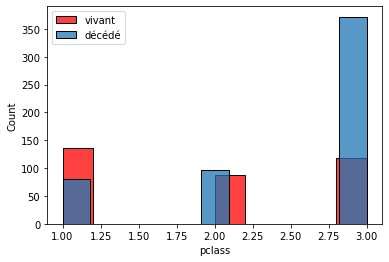

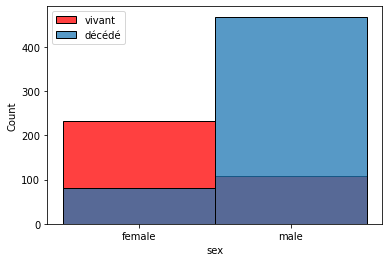

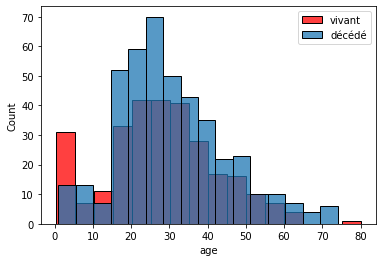

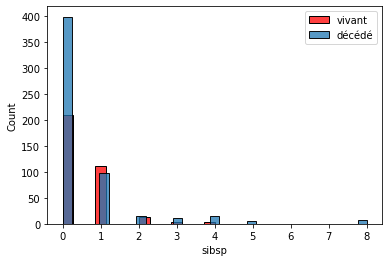

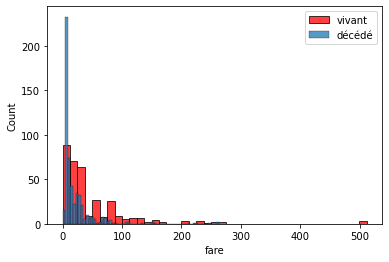

In [45]:
titanic = titanic[['survived', 'pclass', 'sex', 'age', 'sibsp', 'fare']]
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'fare']]


positive_df = df[df['survived'] == 1]
negative_df = df[df['survived'] == 0]


for col in df.columns:
    plt.figure()
    sns.histplot(positive_df[col], label='vivant', color ="r")
    sns.histplot(negative_df[col], label='décédé')
    plt.legend()

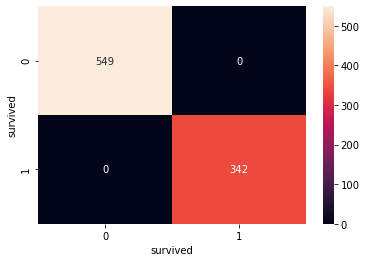

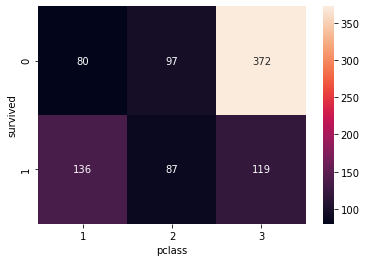

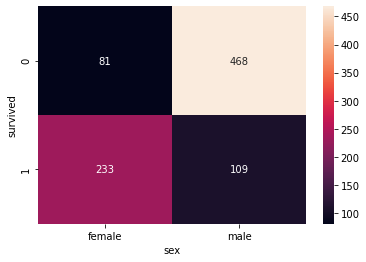

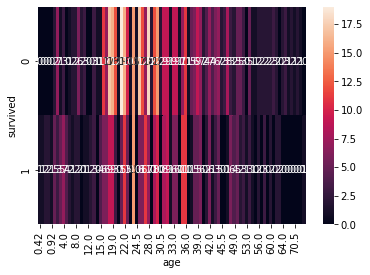

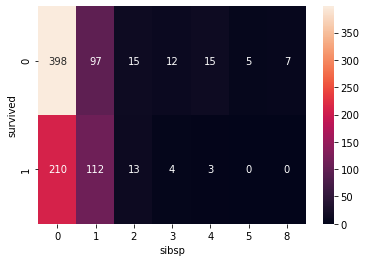

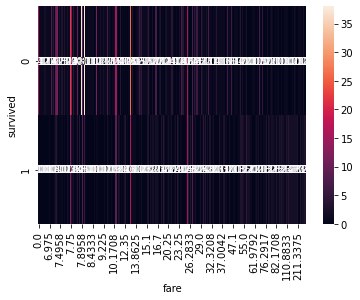

In [28]:
for col in df.columns:
    plt.figure()
    sns.heatmap(pd.crosstab(df['survived'], df[col]), annot=True, fmt='d')

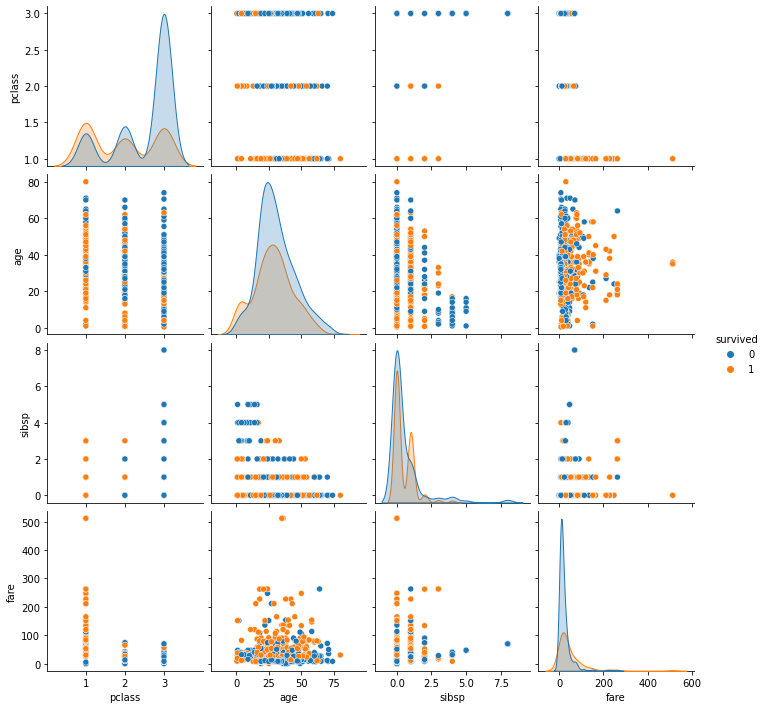

In [29]:
sns.pairplot(df, hue = 'survived')

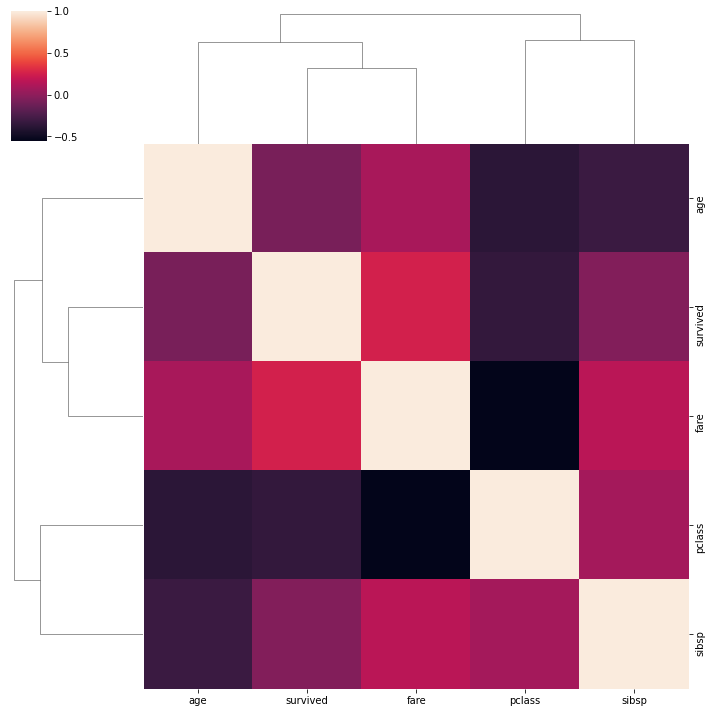

In [30]:
sns.clustermap(df.corr())

## On réalise les modifications nécessaires 

In [48]:
titanic = pd.read_csv("train.csv")
titanic.columns= titanic.columns.str.strip().str.lower()
titanic = titanic[['survived', 'pclass', 'sex', 'age', 'sibsp', 'fare']]


titanic['age'].fillna((titanic['age'].mean()), inplace=True)

age_array = titanic[titanic["age"]!=np.nan]["age"]

titanic["age"].replace(np.nan,age_array.mean())

titanic["fare"] = titanic["fare"].map(lambda i: np.log(i) if i > 0 else 0)
#titanic.dropna(axis=0, inplace=True)
titanic['sex'].replace(['male', 'female'], [0, 1], inplace=True)

## On commence par normaliser les variables (même échelle)

In [49]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

titanic_norm = MinMaxScaler().fit_transform(titanic)
print(titanic_norm)

titanic = pd.DataFrame(titanic_norm, columns = ['survived', 'pclass', 'sex', 'age', 'sibsp', 'fare'])


[[0.         1.         0.         0.27117366 0.125      0.31752073]
 [1.         0.         1.         0.4722292  0.125      0.68387312]
 [1.         1.         1.         0.32143755 0.         0.33178925]
 ...
 [0.         1.         1.         0.36792055 0.125      0.5056719 ]
 [1.         0.         0.         0.32143755 0.         0.5451539 ]
 [0.         1.         0.         0.39683338 0.         0.32821022]]


## On sépare le dataset en données d'entrainement du modèle et de test du modèle

In [50]:
from sklearn.model_selection import train_test_split

# X doit être les données, et Y les targets (survie ou non)

y = titanic['survived']
X = titanic.drop('survived', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

print('Train set:', X_train.shape)
print('Test set:', X_test.shape)
print(X_train.dtypes)

Train set: (712, 5)
Test set: (179, 5)
pclass    float64
sex       float64
age       float64
sibsp     float64
fare      float64
dtype: object


## On entraine un premier modèle

In [51]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=1)

model_knn.fit(X_train, y_train)

print('train score:', model_knn.score(X_train, y_train))
print('test score:', model_knn.score(X_test, y_test))

train score: 0.976123595505618
test score: 0.8156424581005587


## On essaie de l'améliorer via la cross-validation

In [53]:
from sklearn.model_selection import cross_val_score

model_knn = KNeighborsClassifier()
cross_val_score(model_knn, X_train, y_train, cv=5, scoring='accuracy')

array([0.79020979, 0.84615385, 0.79577465, 0.85211268, 0.78169014])

## On s'intéresse à l'impact du nombre de voisins k sur la pertinence du modèle

C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass param_name=n_neighbors, param_range=[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


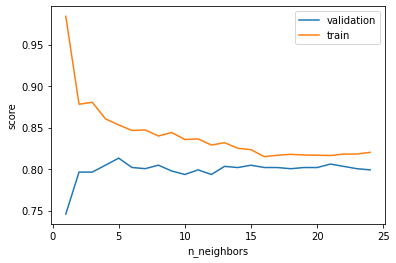

In [54]:
from sklearn.model_selection import validation_curve

model_knn = KNeighborsClassifier()
k = np.arange(1, 25)

train_score, val_score = validation_curve(model_knn, X_train, y_train,
                                          'n_neighbors', k, cv=5)

plt.plot(k, val_score.mean(axis=1), label='validation')
plt.plot(k, train_score.mean(axis=1), label='train')

plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

## On améliore le modèle en testant toute sortes de combinaisons de paramètres

In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': np.arange(1, 20),
              'metric': ['euclidean', 'manhattan'],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'weights': ['uniform', 'distance']})

In [56]:
print(grid.best_score_)
print(grid.best_params_)

0.8145868216290753
{'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 17, 'weights': 'distance'}


In [57]:
model_knn = grid.best_estimator_
model_knn.score(X_test, y_test)

0.8268156424581006

## On analyse maintenant la qualité du modèle KNN

In [58]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import learning_curve

def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

[[102   9]
 [ 22  46]]
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87       111
         1.0       0.84      0.68      0.75        68

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



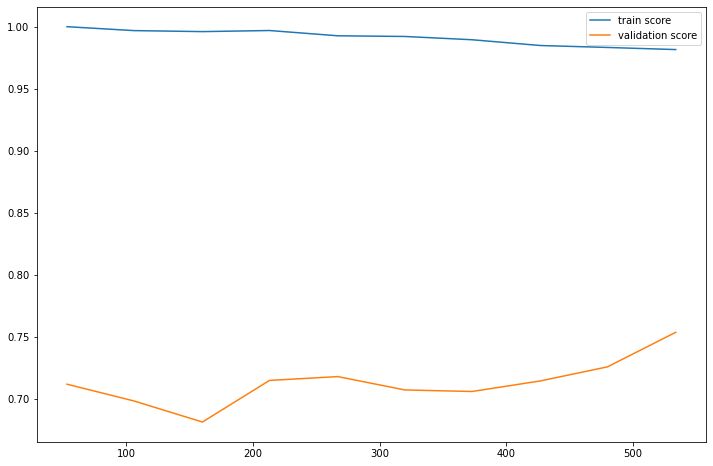

In [59]:
evaluation(model_knn)

<AxesSubplot:>

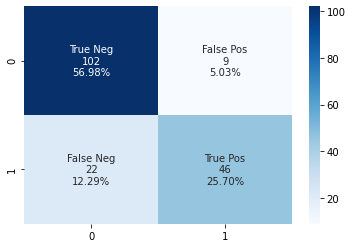

In [60]:
cf_matrix = confusion_matrix(y_test, model_knn.predict(X_test))
labels = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures

## On teste un nouveau modèle en RandomForest

In [62]:
model_randomf = make_pipeline(PolynomialFeatures(2), SelectKBest(f_classif, k=5),
                      RandomForestClassifier(random_state=0))

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[[100  11]
 [ 21  47]]
              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86       111
         1.0       0.81      0.69      0.75        68

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\Vianney\anaco

C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Vianney\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\Vianney\anaco

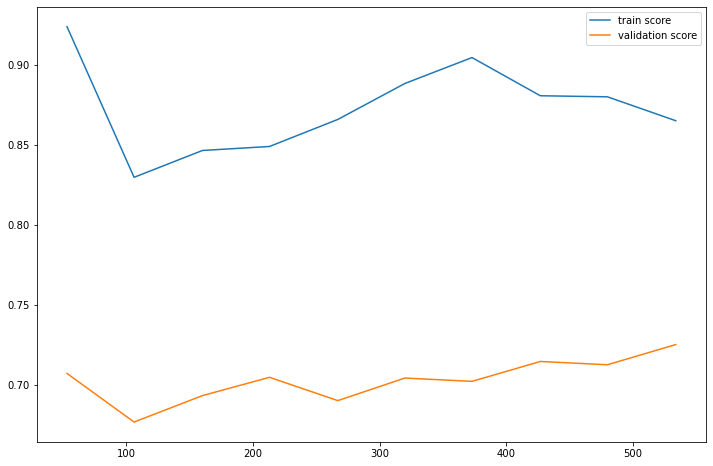

In [63]:
evaluation(model_randomf)

## On teste également le SVM SVC

In [64]:
from sklearn.svm import SVC
model_svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [65]:
model_svc

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

[[103   8]
 [ 24  44]]
              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87       111
         1.0       0.85      0.65      0.73        68

    accuracy                           0.82       179
   macro avg       0.83      0.79      0.80       179
weighted avg       0.82      0.82      0.82       179



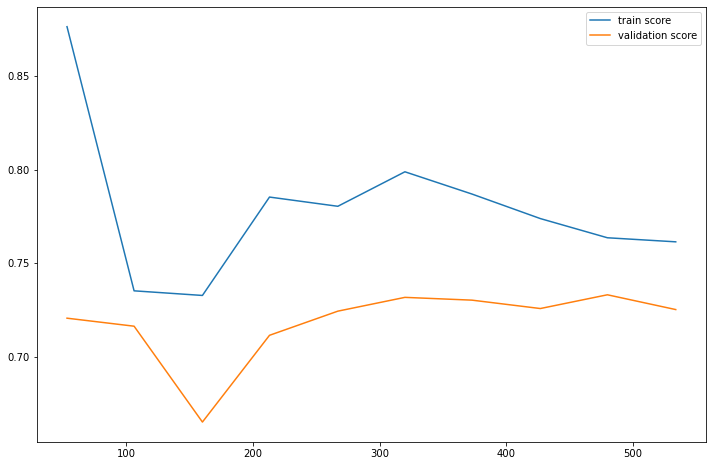

In [66]:
evaluation(model_svc)

In [97]:
param_grid_svc = {'C': [0.1,1, 10, 100],
                  'gamma': [1,0.1,0.01,0.001],
                  'kernel': ['rbf', 'poly', 'sigmoid']}

In [98]:
grid_svc = GridSearchCV(SVC(),param_grid_svc,refit=True,verbose=2)
grid_svc.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=poly .....................................
[CV] ...................... C=1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=1, gamma=0.1, kernel=poly .....................................
[CV] ...................... C=1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=1, gamma=0.1, kernel=poly .....................................
[CV] ...................... C=1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=1, gamma=0.1, kernel=poly .....................................
[CV] ...................... C=1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=1, gamma=0.1, kernel=poly .....................................
[CV] ...................... C=1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=1, gamma=0.1, kernel=sigmoid ..................................
[CV] ................... C=1, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=0.1, kernel=sigmoid ..................................
[CV] .

[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV] .................... C=10, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV] .................... C=10, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV] .................... C=10, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.01, kernel=poly ...................................
[CV] .

[CV] .................... C=100, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=100, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=100, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.01, kernel=poly ..................................
[CV] ................... C=100, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.01, kernel=poly ..................................
[CV] ................... C=100, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.01, kernel=poly ..................................
[CV] ................... C=100, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.01, kernel=poly ..................................
[CV] ................... C=100, gamma=0.01, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.01, kernel=poly ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    3.3s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [99]:
print(grid_svc.best_estimator_)

SVC(C=10, gamma=1, kernel='poly')


[[103   8]
 [ 27  41]]
              precision    recall  f1-score   support

         0.0       0.79      0.93      0.85       111
         1.0       0.84      0.60      0.70        68

    accuracy                           0.80       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.81      0.80      0.80       179



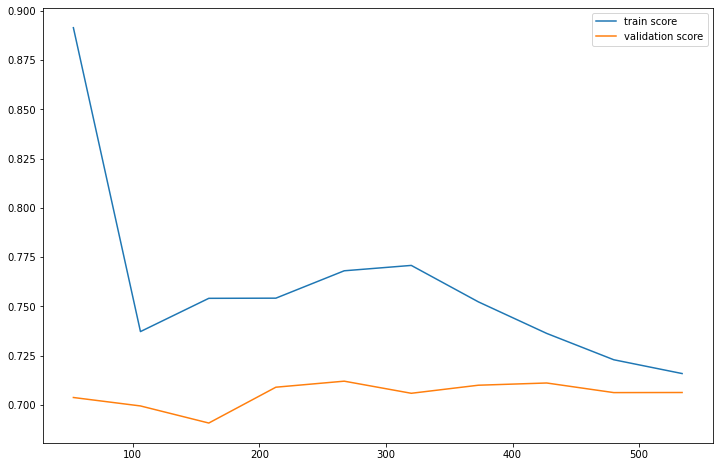

In [100]:
evaluation(grid_svc.best_estimator_)

## On exporte le modèle choisi en .pkl pour usages futurs

In [67]:
import pickle

Pkl_Filename = "model_titanic.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model_knn, file)

In [89]:
with open(Pkl_Filename, 'rb') as file:  
    pickled_model = pickle.load(file)

pickled_model

test_ultime = pd.read_csv("test.csv")

test_ultime = test_ultime[[ 'Pclass', 'Sex', 'Age', 'SibSp', 'Fare']]

test_ultime.columns= test_ultime.columns.str.strip().str.lower()

test_ultime['age'].fillna((test_ultime['age'].mean()), inplace=True)
test_ultime["fare"] = test_ultime["fare"].map(lambda i: np.log(i) if i > 0 else 0)
test_ultime['sex'].replace(['male', 'female'], [0, 1], inplace=True)


print(test_ultime.head(5))

test_ultime = MinMaxScaler().fit_transform(test_ultime)

test_ultime = pd.DataFrame(test_ultime, columns = ['pclass', 'sex', 'age', 'sibsp', 'fare'])

Ypredict = pickled_model.predict(test_ultime)  

Ypredict


df_final = pd.DataFrame(Ypredict, columns = ['Survived'])


df_final['Survived'].value_counts()


   pclass  sex   age  sibsp      fare
0       3    0  34.5      0  2.057860
1       3    1  47.0      1  1.945910
2       2    0  62.0      0  2.270836
3       3    0  27.0      0  2.159003
4       3    1  22.0      1  2.508582


0.0    261
1.0    157
Name: Survived, dtype: int64

In [96]:
test = pd.read_csv("test.csv")

passengerID = test["PassengerId"]

submission = df_final.merge(passengerID, left_index=True, right_index=True)
print(submission.head(10))
print(passengerID.isna)

print(passengerID.shape)
print(df_final.shape)
print(submission.shape)

submission = submission[["PassengerId", "Survived"]]

submission = submission.astype({"PassengerId": int, "Survived": int})

submission.to_csv(r'submission.csv', index = False)

   Survived  PassengerId
0       0.0          892
1       0.0          893
2       0.0          894
3       0.0          895
4       0.0          896
5       0.0          897
6       1.0          898
7       0.0          899
8       1.0          900
9       0.0          901
<bound method Series.isna of 0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64>
(418,)
(418, 1)
(418, 2)
